In [1]:
# 2. 정규표현식으로 해시태그를 제거해서 전처리 하는 것 보단 해시태그를 이용한 분석을 하는 것도 좋다고 생각함

In [2]:
import os
import re
import platform

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
from collections import Counter
import swifter
from konlpy.tag import Kkma, Komoran, Okt, Mecab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [3]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def Fontmanager():

    plt.rcParams['axes.unicode_minus'] = False

    if platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Darwin':
        path = '/Library/Fonts/Arial Unicode.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='AppleGothic')
    elif platform.system() == 'Linux':
        path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family='NanumBarunGothic')
    else:
        print('Unknown system... sorry~~~~~~')
    print(f"해당 pc의 운영 체제는 {platform.system()}이며 {font_name}로 설정되었습니다")  
    return path

In [5]:
path = Fontmanager()

해당 pc의 운영 체제는 Darwin이며 Arial Unicode MS로 설정되었습니다


In [6]:
election = pd.read_csv('dataset/election.csv')
election = election.drop_duplicates()

In [7]:
women_policy = pd.read_csv('dataset/women_policy.csv')
# 혹시 모를 중복제거
women_policy = women_policy.drop_duplicates()

In [8]:
# 혹시 모를 nan값 확인
women_policy.isna().sum()

datetime    0
id          0
text        0
username    0
dtype: int64

In [9]:
# 정규표현식 이용한 전처리
def clean(text):
    #\n 공백 제거
    text = re.sub('\n',' ',str(text))
    # URL 제거
    text = re.sub('https://[A-Za-z0-9./]*','',str(text))
    # 한글자 제거 (ex:ㅋㅋ, ㅜㅜ)
    text = re.sub('([ㄱ-ㅎㅏ-ㅣ])+', '', str(text))
    # @알파벳 제거 
    return str(text)

In [10]:
women_policy['text'] = women_policy['text'].apply(lambda x : clean(x))

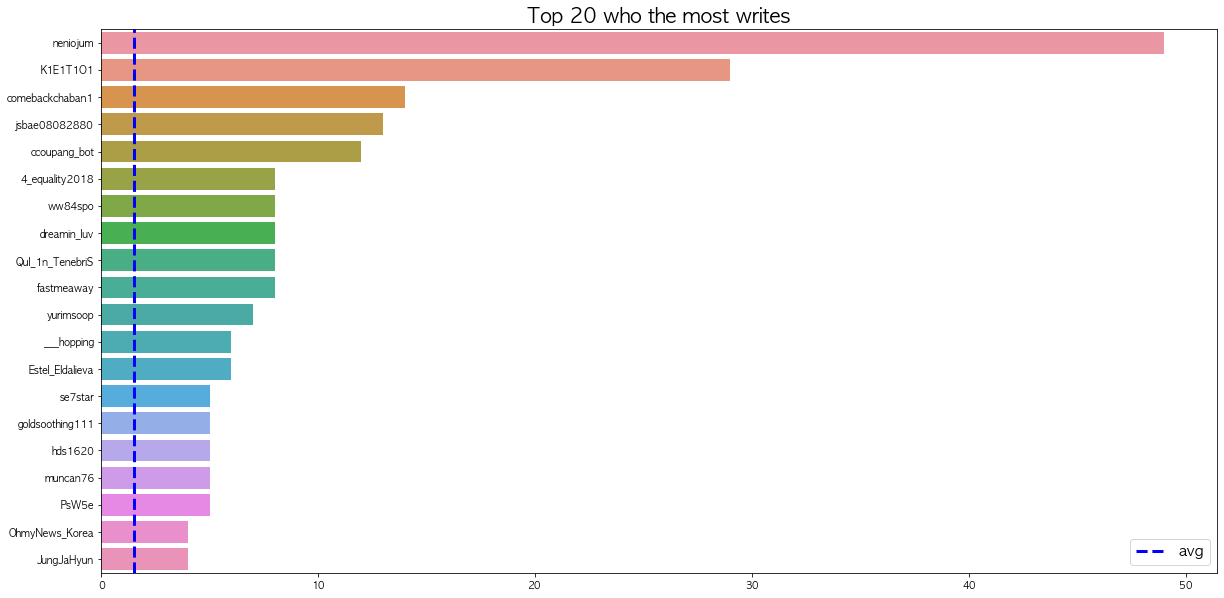

In [11]:
# 어떤 유저가 가장 많이 트윗을 썻는지
plt.figure(figsize=(20,10))
sns.barplot(x=women_policy['username'].value_counts()[:20].values, 
            y=women_policy['username'].value_counts()[:20].index,
           orient='h')
plt.title('Top 20 who the most writes', fontsize=20)
plt.axvline(x=np.average(women_policy['username'].value_counts().values), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('Top 20 who the most writes')

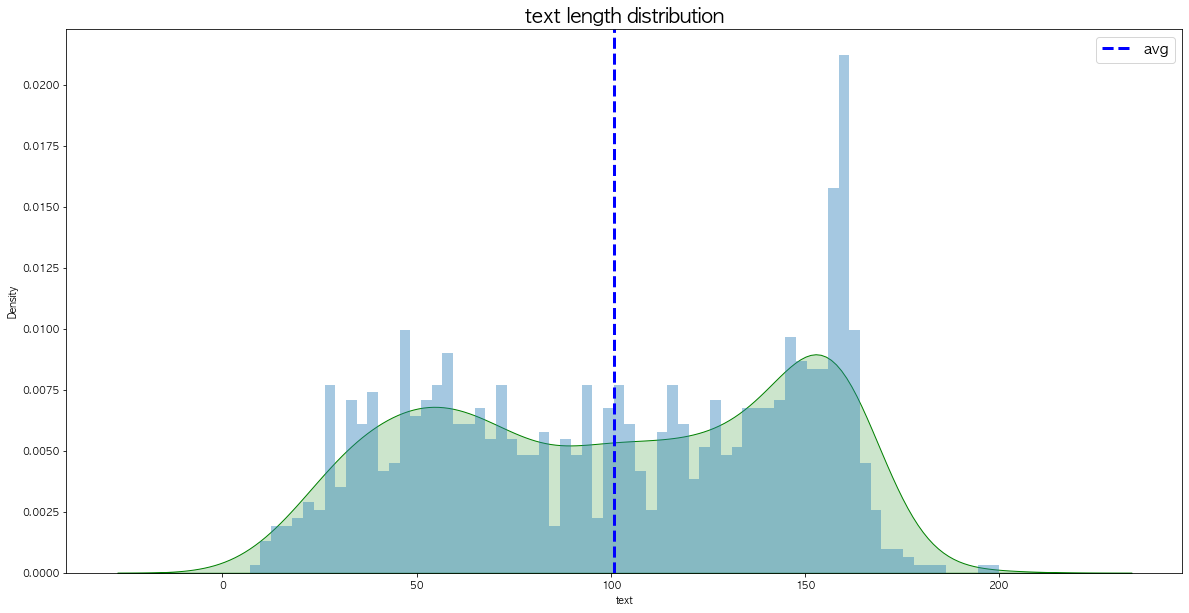

In [12]:
# 전체 문장 길이 분포
plt.figure(figsize=(20,10))
sns.distplot(a=women_policy['text'].str.len(), bins=70, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('text length distribution', fontsize=20)
plt.axvline(x=np.average(women_policy['text'].str.len()), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)
# save_fig('text length distribution')

In [13]:
# tokenizer
kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

# stopwords list
stop_words = pd.read_csv('dataset/한국어불용어100.txt', sep = "\t", engine='python')
stop_words = list(stop_words["word"])

In [14]:
def common_words(words, k):
    c = Counter(words)
    cw = c.most_common(k)
    return c, cw

In [15]:
def tokenizing(df, tokenizer):
    nouns = df.swifter.apply(lambda x : tokenizer.nouns(x))
    nouns_list = np.concatenate(nouns.tolist()).tolist()
    words = [n for n in nouns_list if len(n) > 1] 
    return nouns_list, words

In [16]:
def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word not in stop_words:
            words_new.append(word)
    return words_new

In [17]:
def wordcloud(c):
    wc = WordCloud(font_path='Arial Unicode', width=2000, height=1200, background_color ='white', scale=2.0, max_font_size=250)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize = (12, 6), facecolor = None) 
    plt.imshow(gen)
    plt.axis("off")
    plt.tight_layout(pad=0)
    # save_fig("most_common_words_wordcloud")

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

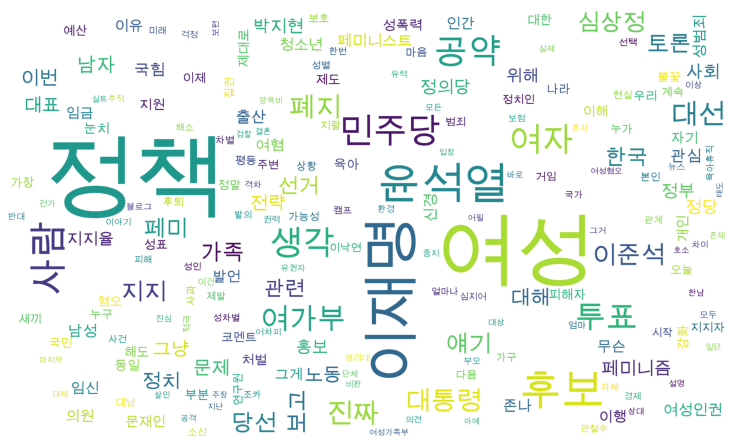

In [18]:
# wordcloud
nouns_list, words = tokenizing(women_policy['text'], okt)
words_new = stopwords(words, stop_words)
c, cw = common_words(words_new, 200)
wordcloud(c)

In [19]:
# 단어 길이 분포
nouns = women_policy['text'].swifter.apply(lambda x : okt.nouns(x))

Pandas Apply:   0%|          | 0/1128 [00:00<?, ?it/s]

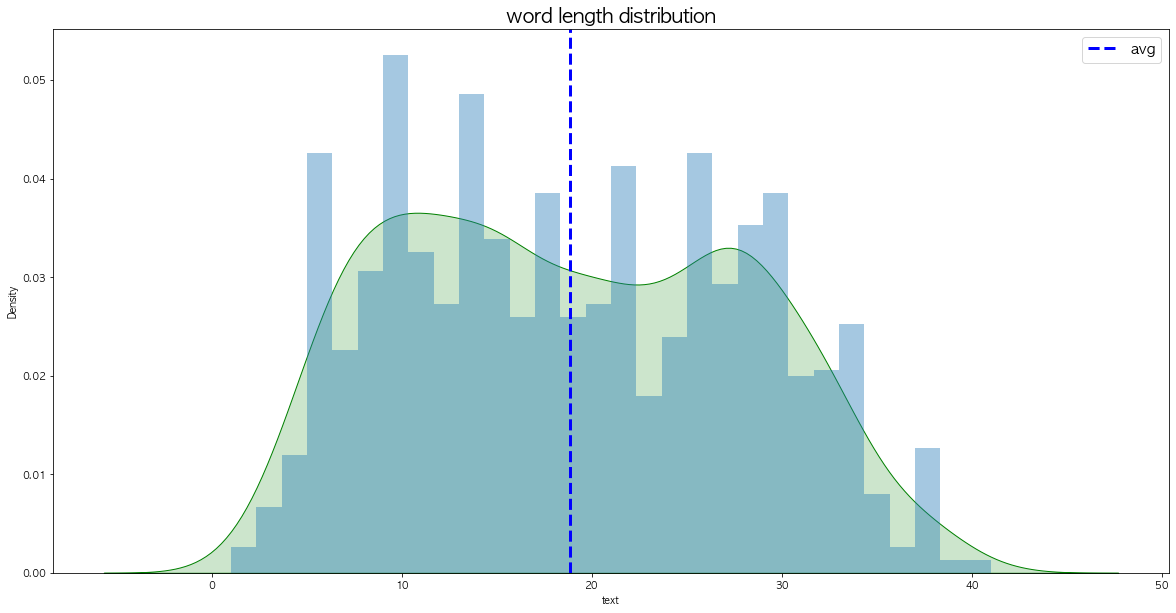

In [20]:
plt.figure(figsize=(20,10))
sns.distplot(a=nouns.str.len(), bins=30, kde=True,
             kde_kws={"color":"g", "alpha":0.2, "linewidth":1, "shade":True})
plt.title('word length distribution', fontsize=20)
plt.axvline(x=nouns.str.len().mean(), color='b', linestyle='--', linewidth=3, 
            label='avg')
plt.legend(fontsize=15)

In [21]:
# stopword 단어 분포

def stopwords(words, stop_words):
    words_new = []

    for word in words:
        if word in stop_words:
            words_new.append(word)
    return words_new

In [ ]:
# 불용어 사전에 '여자' 등의 단어가 포함되어 있어서 뺐음

In [22]:
words_new = stopwords(words, stop_words)

No handles with labels found to put in legend.


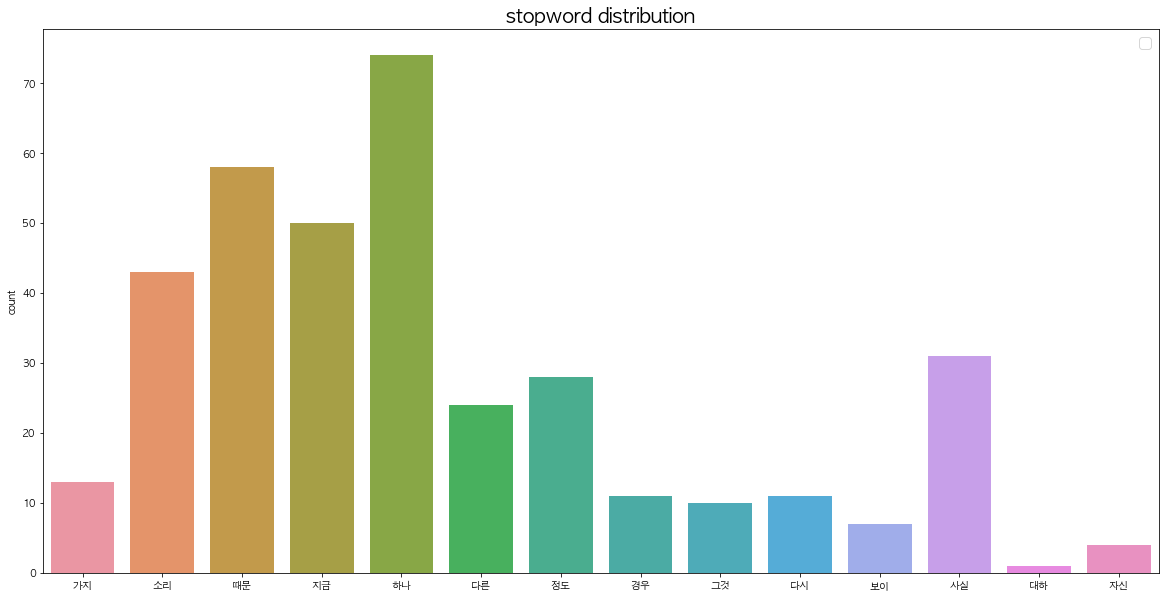

In [26]:
plt.figure(figsize=(20,10))
sns.countplot(words_new)
plt.title('stopword distribution', fontsize=20)
plt.legend(fontsize=15)

In [28]:
# ngram exploration
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [33]:
new = women_policy['text'].str.split()
new = new.values.tolist()

In [38]:
new

[['대통령을',
  '본',
  '이래',
  '가장',
  '강한',
  '발언이',
  '나왔음',
  '각하',
  '충성충성충성',
  '민주당의',
  '여성정책',
  '노동정책',
  '환경정책',
  '열심히',
  '홍보하고',
  '또',
  '영업하겠슴다',
  '문재인',
  '너무너무',
  '사랑하고',
  '존경합니다'],
 ['문대통령은',
  '지지하고',
  '이재명은',
  '존나',
  '싫어서',
  '뽑을',
  '사람',
  '없어가지고',
  '괴롭네',
  '어쩌네',
  '하는',
  '거',
  '진짜',
  '웃김',
  '여성정책',
  '가지고',
  '자빠진',
  '거면',
  '제대로',
  '읽고',
  '왔으면',
  '좋겠음',
  '근데',
  '지난',
  '대선',
  '관련으로',
  '이재명이',
  '싫어서',
  '못',
  '뽑겠다고',
  '하는',
  '사람들은',
  '너무',
  '혼자서',
  '과몰입하면서',
  '사는거',
  '아닌가?'],
 ['언제는',
  '피해자',
  '언급과',
  '사과를',
  '안',
  '했으니',
  '민주당에',
  '돌아서겠다',
  '하더니,',
  '이제는',
  '살인자가',
  '내세우는',
  '허울뿐인',
  '여성정책을',
  '올려치네.',
  '이쯤이면',
  '보확찢',
  '발언도',
  '조작이라고',
  '하겠는데.',
  '그냥',
  '원래',
  '추종자였던',
  '거',
  '아닌가',
  '싶고~'],
 ['신남성연대',
  '배인규랑',
  '하등',
  '다를바',
  '없는',
  '놈을',
  '당',
  '공식',
  '직위에',
  '앉혀놓은',
  '안철수를',
  '여성',
  '정책으로',
  '영업한다?',
  '양심은',
  '있으신지'],
 ['여가부',
  '폐지하겠다는',
  '말은',
  '빈대',
  '잡겠다고',
  '초가삼간',
  '태우는',
  '소리와',
 

In [35]:
corpus = sum(new, [])

In [36]:
corpus

['대통령을',
 '본',
 '이래',
 '가장',
 '강한',
 '발언이',
 '나왔음',
 '각하',
 '충성충성충성',
 '민주당의',
 '여성정책',
 '노동정책',
 '환경정책',
 '열심히',
 '홍보하고',
 '또',
 '영업하겠슴다',
 '문재인',
 '너무너무',
 '사랑하고',
 '존경합니다',
 '문대통령은',
 '지지하고',
 '이재명은',
 '존나',
 '싫어서',
 '뽑을',
 '사람',
 '없어가지고',
 '괴롭네',
 '어쩌네',
 '하는',
 '거',
 '진짜',
 '웃김',
 '여성정책',
 '가지고',
 '자빠진',
 '거면',
 '제대로',
 '읽고',
 '왔으면',
 '좋겠음',
 '근데',
 '지난',
 '대선',
 '관련으로',
 '이재명이',
 '싫어서',
 '못',
 '뽑겠다고',
 '하는',
 '사람들은',
 '너무',
 '혼자서',
 '과몰입하면서',
 '사는거',
 '아닌가?',
 '언제는',
 '피해자',
 '언급과',
 '사과를',
 '안',
 '했으니',
 '민주당에',
 '돌아서겠다',
 '하더니,',
 '이제는',
 '살인자가',
 '내세우는',
 '허울뿐인',
 '여성정책을',
 '올려치네.',
 '이쯤이면',
 '보확찢',
 '발언도',
 '조작이라고',
 '하겠는데.',
 '그냥',
 '원래',
 '추종자였던',
 '거',
 '아닌가',
 '싶고~',
 '신남성연대',
 '배인규랑',
 '하등',
 '다를바',
 '없는',
 '놈을',
 '당',
 '공식',
 '직위에',
 '앉혀놓은',
 '안철수를',
 '여성',
 '정책으로',
 '영업한다?',
 '양심은',
 '있으신지',
 '여가부',
 '폐지하겠다는',
 '말은',
 '빈대',
 '잡겠다고',
 '초가삼간',
 '태우는',
 '소리와',
 '다를',
 '바',
 '없습니다.',
 '여가부의',
 '여성',
 '정책이',
 '젠더',
 '갈등의',
 '원인이',
 '되기도',
 '하지만,',
 '청소년',
 '복지',
 '정책',
 '등'

In [34]:
new

[['대통령을',
  '본',
  '이래',
  '가장',
  '강한',
  '발언이',
  '나왔음',
  '각하',
  '충성충성충성',
  '민주당의',
  '여성정책',
  '노동정책',
  '환경정책',
  '열심히',
  '홍보하고',
  '또',
  '영업하겠슴다',
  '문재인',
  '너무너무',
  '사랑하고',
  '존경합니다'],
 ['문대통령은',
  '지지하고',
  '이재명은',
  '존나',
  '싫어서',
  '뽑을',
  '사람',
  '없어가지고',
  '괴롭네',
  '어쩌네',
  '하는',
  '거',
  '진짜',
  '웃김',
  '여성정책',
  '가지고',
  '자빠진',
  '거면',
  '제대로',
  '읽고',
  '왔으면',
  '좋겠음',
  '근데',
  '지난',
  '대선',
  '관련으로',
  '이재명이',
  '싫어서',
  '못',
  '뽑겠다고',
  '하는',
  '사람들은',
  '너무',
  '혼자서',
  '과몰입하면서',
  '사는거',
  '아닌가?'],
 ['언제는',
  '피해자',
  '언급과',
  '사과를',
  '안',
  '했으니',
  '민주당에',
  '돌아서겠다',
  '하더니,',
  '이제는',
  '살인자가',
  '내세우는',
  '허울뿐인',
  '여성정책을',
  '올려치네.',
  '이쯤이면',
  '보확찢',
  '발언도',
  '조작이라고',
  '하겠는데.',
  '그냥',
  '원래',
  '추종자였던',
  '거',
  '아닌가',
  '싶고~'],
 ['신남성연대',
  '배인규랑',
  '하등',
  '다를바',
  '없는',
  '놈을',
  '당',
  '공식',
  '직위에',
  '앉혀놓은',
  '안철수를',
  '여성',
  '정책으로',
  '영업한다?',
  '양심은',
  '있으신지'],
 ['여가부',
  '폐지하겠다는',
  '말은',
  '빈대',
  '잡겠다고',
  '초가삼간',
  '태우는',
  '소리와',
 

In [40]:
new = sum(new, [])

In [ ]:
stop_words

In [ ]:
nouns.str.len().hist()

In [ ]:
nouns.str.len().mean()

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist()

In [ ]:
mecab.nouns(women_policy['text'][0])

In [ ]:
nouns = women_policy['text'].swifter.apply(lambda x : mecab.nouns(x))

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
wordcloud(c)

In [ ]:
np.concatenate(women_policy['text'].tolist()).tolist()

In [ ]:
women_policy['text'].tolist()

In [ ]:
women_policy['text'].swifter.apply(lambda x : komoran.nouns(x))

In [ ]:
len(women_policy['text'])

In [ ]:
word_list = []
for i in range(len(women_policy['text'])):
    word = mecab.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
word_list = []
for i in range(15):
    word = komoran.nouns(women_policy['text'][i])
    word_list.append(word)

In [ ]:
new_word_list = np.concatenate(word_list).tolist()

In [ ]:
words = [n for n in new_word_list if len(n) > 1] 

In [ ]:
words

In [ ]:
words_new = stopwords(words, stop_words)

In [ ]:
words_new

In [ ]:
c, cw = common_words(words_new, 200)

In [ ]:
= np.concatenate(word_list).tolist()

In [ ]:
len(women_policy['text'])

In [ ]:
word = komoran.nouns(women_policy['text'][0])
word

In [ ]:
women_policy['text'][0]

In [ ]:
komoran.pos(women_policy['text'].tolist())